In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.metrics import f1_score
import pandas as pd

In [3]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *
from augmentation import cutout
from data_loader import *

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [5]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

In [6]:
split_handler = SplitByPatient(hem_patients, all_patints)

In [7]:
train_regex = re.compile(r'(fold_0|fold_1)')
val_regex = re.compile(r'(fold_2)')

hem_train, all_train, hem_val, all_val = split_handler.split_by_regex(train_regex, val_regex)

In [8]:
pat = re.compile(r'^.*(hem|all).bmp$')

def get_label(fn):
    return pat.search(str(fn)).group(1)

In [9]:
valid = ImageItemListCell(hem_val+all_val)
train = ImageItemListCell(hem_train+all_train)

item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_label)

In [10]:
def get_data(bs, size, tfms):
    data  = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, 
                                      ds_tfms=tfms, padding_mode='zeros',
                                      resize_method=ResizeMethod.PAD)
    data = data.normalize()
    return data

#### Define function to optimise

In [11]:
def optimise_augmentation(params, random_state=42):
    
    np.random.seed(random_state)
    
    max_rotate = params['max_rotate']
    max_lighting = params['max_lighting']
    max_zoom = params['max_zoom']
    max_warp = params['max_warp']
    cutout_length = params['cutout_length']
    squish_scale = params['squish_scale']
    
    cut = TfmLighting(cutout)
    tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=max_rotate,  
                      max_lighting=max_lighting, 
                      max_zoom=max_zoom, 
                      max_warp=max_warp,
                      p_affine=0.75,
                      p_lighting=0.75,  
                      xtra_tfms=[squish(scale=squish_scale), cut(n_holes=5, length=cutout_length)],
                     )
    
    size = 224
    bs = 128
    data = get_data(bs, size, tfms)
    
    learn = create_cnn(data, models.resnet50, 
                   metrics=[error_rate],  
                   callback_fns=[partial(SaveModelCallback, monitor="error_rate", mode='min', name='opti_test')],
                  ).mixup().to_fp16()
    
    lr = 1e-2
    learn.fit_one_cycle(4, lr)
    
    preds, y = learn.get_preds()
    preds = preds.argmax(1)
    
    return 1 - f1_score(to_np(preds), to_np(y))

In [28]:
# possible values of parameters
space={'max_rotate': hp.quniform('max_rotate', 0, 90, 5),
       'max_lighting' : hp.quniform('max_lighting', 0.01, 0.8, 0.05),
       'max_zoom' : hp.quniform('max_zoom', 0.5, 1.5, 0.1),
       'max_warp' : hp.quniform('max_warp', 0.01, 0.75, 0.05),
       'cutout_length' : hp.quniform('cutout_length', 0, 0.4, 0.05),
       'squish_scale' : hp.quniform('squish_scale', 0.5, 1.5, 0.1),
      }

In [29]:
trials = Trials()

In [30]:
n_iter = 16*4 #16 gleich eine stunde

In [31]:
gc.collect();

In [32]:
%%time

best=fmin(fn=optimise_augmentation, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(42) # fixing random state for the reproducibility
         )

CPU times: user 3h 25min 32s, sys: 57min 42s, total: 4h 23min 15s
Wall time: 5h 17min 9s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4c52a7a58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa4c45e13c8>], dtype=object)

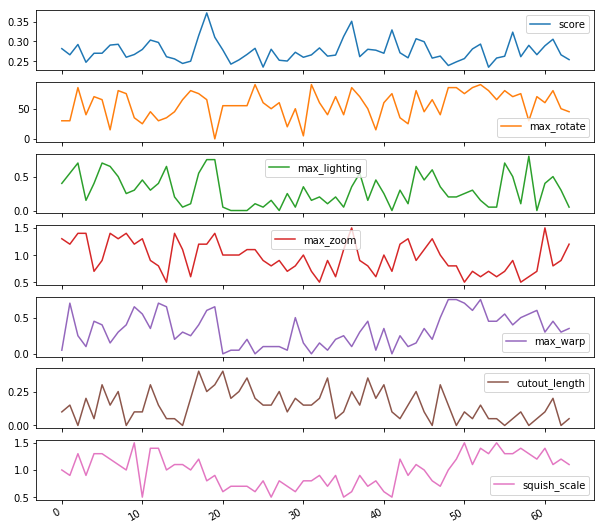

In [33]:
sa_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_rotate'][0],
                      x['misc']['vals']['max_lighting'][0],
                      x['misc']['vals']['max_zoom'][0],
                      x['misc']['vals']['max_warp'][0],
                      x['misc']['vals']['cutout_length'][0],
                      x['misc']['vals']['squish_scale'][0],                     
                     ] for x in trials.trials])

sa_results_df=pd.DataFrame(sa_results,
                           columns=['score', 'max_rotate', 'max_lighting', 'max_zoom', 
                                    'max_warp', 'cutout_length', 'squish_scale'])
sa_results_df.plot(subplots=True,figsize=(10, 10))